# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [3]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import matplotlib.pyplot as plt 
import datetime
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV



# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
# EDA - Understand table structure,document observations and clean the dataset

In [5]:
# 1.transcript dataset

In [6]:
# to see number of rows and columns in the dataset
print(transcript.head())
print(transcript.info())
print(transcript.shape)

            event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None
(306534, 4)


In [7]:
# check for duplicates
print(transcript.columns.duplicated().sum())
print(transcript.isna().sum())

0
event     0
person    0
time      0
value     0
dtype: int64


In [8]:
# describing the dataset
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [9]:
#Time ranges from 0 to 714 hours

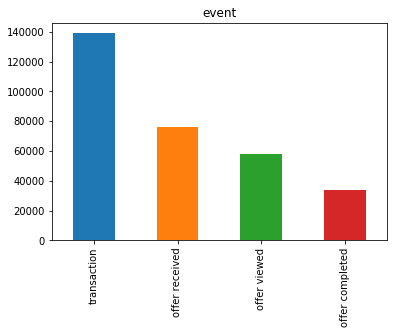

In [10]:
# checking possible values for the event
transcript.event.value_counts()
transcript['event'].value_counts().plot(kind='bar')
plt.title('event');

In [11]:
# Event has four values: Transaction, Offer received, Offer viewed and Offer completed. 
# we can see that apprx 80,000 of offer's received apprx. 60,000 were viewed and apprx. 40,000 were completed

In [12]:
# Chceking values for Transaction event
Transaction_event_check = transcript[transcript.event=='transaction']
Transaction_event_check.head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [13]:
# Checking possible values for the value column
transcript.value.sample(20)

217876     {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
293818     {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
42902                                      {'amount': 0.96}
221631    {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
194973                                    {'amount': 33.68}
89259                                     {'amount': 13.29}
142771                                    {'amount': 28.74}
207316     {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
41519                                      {'amount': 2.32}
296306                                     {'amount': 0.12}
270833     {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
254902     {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
299374                                     {'amount': 7.92}
164092                                      {'amount': 1.1}
193950                                     {'amount': 0.59}
121461     {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
276274     {'offer id': '5a8bc65990b245e

In [14]:
# Value field is a dictionary field. This column sometimes has offer id and if available amount and reward. 

In [15]:
# additional observations on Transcript dataset
# 1. Categorical variables for event column
# 2. Extract offer_id, amount and reward form the value column and later drop the value column
# 3. Exclude Transaction event from the dataset. it doesnt have any offer id's data in value column. it has the amount data in the value column


In [16]:
# clean the dataset based on above observations

In [17]:
# extract calc_offer_id from value column
transcript['calc_offer_id'] = transcript.value.apply(lambda x:list(x.values())[0])
transcript.head()

,event,person,time,value,calc_offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [18]:
# extracting amount and reward into seperate columns from value column
keys = []
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)

In [19]:
# initializing column values
transcript['amount'] = 0  
transcript['reward'] = 0 


In [20]:
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k == 'amount':
            transcript.at[idx, 'amount'] = row['value'][k]
        if k == 'reward':
            transcript.at[idx, 'reward'] = row['value'][k]

In [21]:
transcript.head()

,event,person,time,value,calc_offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [22]:
# dropping unnecessary columns value
transcript = transcript.drop(columns = ['value'])

In [23]:
transcript.head()

,event,person,time,calc_offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [24]:
# excluding transaction from the event
transcript = transcript[transcript['event'] != 'transaction']
transcript.head()

,event,person,time,calc_offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [25]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306527
Data columns (total 6 columns):
event            167581 non-null object
person           167581 non-null object
time             167581 non-null int64
calc_offer_id    167581 non-null object
amount           167581 non-null int64
reward           167581 non-null int64
dtypes: int64(3), object(3)
memory usage: 8.9+ MB


In [26]:
# 2. Portfolio headset

In [27]:
# to see number of rows,columns in the dataset;structure etc.,
print(portfolio.head())
print(portfolio.info())
print(portfolio.shape)

                       channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null i

In [28]:
# check for duplicates and nulls
print(portfolio.columns.duplicated().sum())
print(portfolio.isna().sum())

0
channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64


In [29]:
# describing the dataset
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [30]:
# grouping by offer type
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

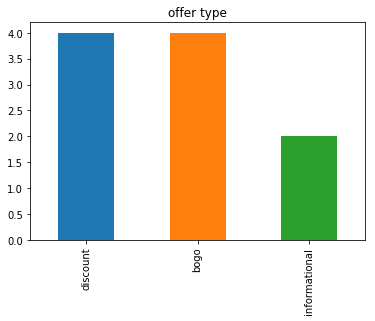

In [31]:
portfolio['offer_type'].value_counts().plot(kind='bar')
plt.title('offer type');

In [32]:
# additional observations on portfolio dataset
# 1. No null values observed in dataset
# 2. three offer types available - bogo, discount and informational. 
# 3. difficulty column is in dollars. need to rescale this feature.
# 4. There are multiple values for channel column. extract channel to multiple columns
# 5. extract offer types into seperate columns.
# 6. Rename column id as offer_id
# 7. Drop channels column

In [33]:
#create new columns from channels column 
portfolio['channel_email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['channel_mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['channel_social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio['channel_web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [34]:
# rename id to offer_id
portfolio.rename(columns = {'id':'offer_id'}, inplace = True)
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [35]:
portfolio = portfolio.drop(columns = ['channels'])

In [36]:
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [37]:
# 3.profile dataset

In [38]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [39]:
# to see number of rows and columns in the dataset
print(profile.head())
print(profile.info())
print(profile.shape)

   age  became_member_on gender                                id    income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5       NaN
3   75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43       NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB
None
(17000, 5)


In [40]:
# check for duplicates and null values
print(profile.columns.duplicated().sum())
print(profile.isna().sum())

0
age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64


In [41]:
#check gender column values
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

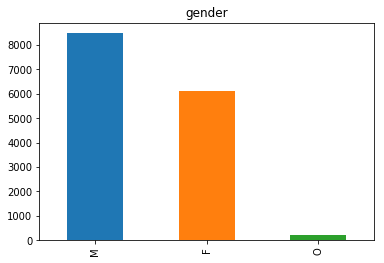

In [42]:
profile['gender'].value_counts().plot(kind='bar')
plt.title('gender');

Text(0.5,1,'By gender')

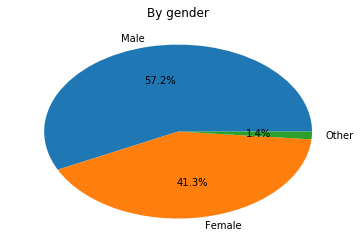

In [43]:
plt.pie(profile['gender'].value_counts(), labels=['Male', 'Female', 'Other'],autopct='%1.1f%%')
plt.title('By gender')

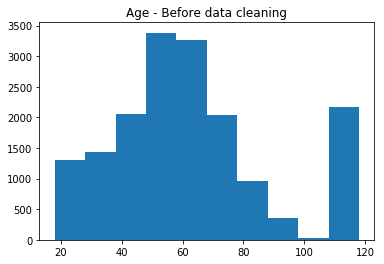

In [44]:
plt.hist(profile['age']);
plt.title('Age - Before data cleaning');

In [45]:
profile[profile.age == 118][['gender','age','income']]

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
9,None,118,NaN
10,None,118,NaN
11,None,118,NaN
17,None,118,NaN
23,None,118,NaN


In [46]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [47]:
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

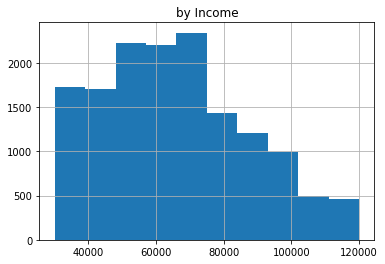

In [48]:
# distribution of income
plt.title('by Income');
profile.income.hist();

In [49]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile['Membership_start_year'] = profile['became_member_on'].dt.year

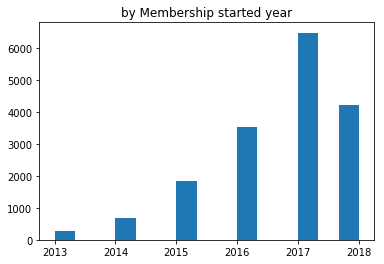

In [50]:
plt.hist(profile['Membership_start_year'], bins = 15);
plt.title('by Membership started year');

In [51]:
# additional observations on Transcript dataset
# Profile dataset have null values for gender,income and age.so this needs to be cleaned in next step 
# Age with 118 seems to be the reason for these nulls and it is an outlier.
# Income varied from 30000 to 120000. from the graph above we can see that most customers income fall between 50000 to 75000
# there are more male customers (57%) compared to female customers (41%).
# there have been more customers joined as member in 2017.
# created new column to extract year from became_member_on column for analyzing
# rename id column to customer_id column
# create age group - youth (20 years and below);  21-40
# drop became_member_on column

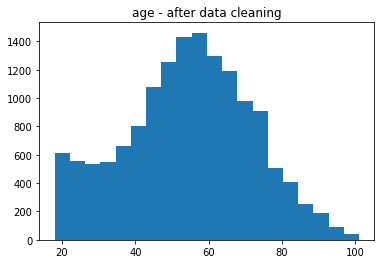

In [52]:
# dropping outlier age 118
profile.drop(profile[profile['age'] == 118].index, inplace=True)
plt.hist(profile['age'], bins = 20);
plt.title('age - after data cleaning');

In [53]:
profile['age'].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [54]:
# # rename id column to customer_id column
profile.rename(columns = {'id':'customer_id'}, inplace = True)

In [55]:
profile['income_range'] = pd.cut(profile['income'], bins=[29999, 60000, 90000, 120001],labels=['Low', 'Medium', 'High'])

In [56]:
# age group classification
profile['age_group'] = pd.cut(profile['age'], bins=[17, 24, 40, 65, 102],labels=['youth', 'young-adult', 'adult', 'senior'])

In [57]:
profile.head()

,age,became_member_on,gender,customer_id,income,Membership_start_year,income_range,age_group
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,High,adult
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,High,senior
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,Medium,senior
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,Low,adult
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,Low,adult


In [58]:
curr_date = profile.became_member_on.max()
profile['membership_tenure'] = (curr_date - profile.became_member_on) 

In [59]:
def membership_group(x):
    """ This function groups membership tenure into ranges. 
    Arguments:
        x : input the membership tenure variable as an integer
    
    Output:
          membership_tenure_group = returns the membership tenure group as a string 
    """
    
    if 0 < x <= 365:
        return '<1year'
    elif 365 < x <= 730:
        return '1-3years'
    elif 731 < x <= 1825: 
        return '3-5years'

In [60]:
# convert the date calculation to days
df=profile
tdcolumn='membership_tenure'
df[tdcolumn] = pd.to_numeric(df[tdcolumn].dt.days, downcast='integer')

In [61]:
profile['membership_tenure_group'] = profile.membership_tenure.apply(membership_group)

In [62]:
profile.head()

,age,became_member_on,gender,customer_id,income,Membership_start_year,income_range,age_group,membership_tenure,membership_tenure_group
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,High,adult,376,1-3years
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,High,senior,443,1-3years
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,Medium,senior,91,<1year
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,Low,adult,167,<1year
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,Low,adult,257,<1year


In [63]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 10 columns):
age                        14825 non-null int64
became_member_on           14825 non-null datetime64[ns]
gender                     14825 non-null object
customer_id                14825 non-null object
income                     14825 non-null float64
Membership_start_year      14825 non-null int64
income_range               14825 non-null category
age_group                  14825 non-null category
membership_tenure          14825 non-null int16
membership_tenure_group    14794 non-null object
dtypes: category(2), datetime64[ns](1), float64(1), int16(1), int64(2), object(3)
memory usage: 984.8+ KB


In [64]:
# dropping became_member_on column
profile= profile.drop(columns = ['age','became_member_on','income'])

In [65]:
profile.head()

,gender,customer_id,Membership_start_year,income_range,age_group,membership_tenure,membership_tenure_group
1,F,0610b486422d4921ae7d2bf64640c50b,2017,High,adult,376,1-3years
3,F,78afa995795e4d85b5d9ceeca43f5fef,2017,High,senior,443,1-3years
5,M,e2127556f4f64592b11af22de27a7932,2018,Medium,senior,91,<1year
8,M,389bc3fa690240e798340f5a15918d5c,2018,Low,adult,167,<1year
12,M,2eeac8d8feae4a8cad5a6af0499a211d,2017,Low,adult,257,<1year


In [66]:
print(profile.isna().sum())

gender                      0
customer_id                 0
Membership_start_year       0
income_range                0
age_group                   0
membership_tenure           0
membership_tenure_group    31
dtype: int64


In [67]:
# Merging transcript, profile and portfolio datasets

In [68]:
# Merging profile and transcript dataset
merge_step1 = transcript.merge(profile, left_on='person', right_on='customer_id', how='left')
# merge above dataset and portfolio dataset
merged_dataset = merge_step1.merge(portfolio,  left_on='calc_offer_id', right_on='offer_id',how ='left')

In [69]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 167580
Data columns (total 22 columns):
event                      167581 non-null object
person                     167581 non-null object
time                       167581 non-null int64
calc_offer_id              167581 non-null object
amount                     167581 non-null int64
reward_x                   167581 non-null int64
gender                     148805 non-null object
customer_id                148805 non-null object
Membership_start_year      148805 non-null float64
income_range               148805 non-null category
age_group                  148805 non-null category
membership_tenure          148805 non-null float64
membership_tenure_group    148503 non-null object
difficulty                 167581 non-null int64
duration                   167581 non-null int64
offer_id                   167581 non-null object
offer_type                 167581 non-null object
reward_y                   167581 non-

In [70]:
# removing rows with NaNs
merged_dataset = merged_dataset.dropna(how='any',axis=0)

In [71]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148503 entries, 0 to 167580
Data columns (total 22 columns):
event                      148503 non-null object
person                     148503 non-null object
time                       148503 non-null int64
calc_offer_id              148503 non-null object
amount                     148503 non-null int64
reward_x                   148503 non-null int64
gender                     148503 non-null object
customer_id                148503 non-null object
Membership_start_year      148503 non-null float64
income_range               148503 non-null category
age_group                  148503 non-null category
membership_tenure          148503 non-null float64
membership_tenure_group    148503 non-null object
difficulty                 148503 non-null int64
duration                   148503 non-null int64
offer_id                   148503 non-null object
offer_type                 148503 non-null object
reward_y                   148503 non-

In [72]:
# Analysis 1: which age group customers mostly belong to

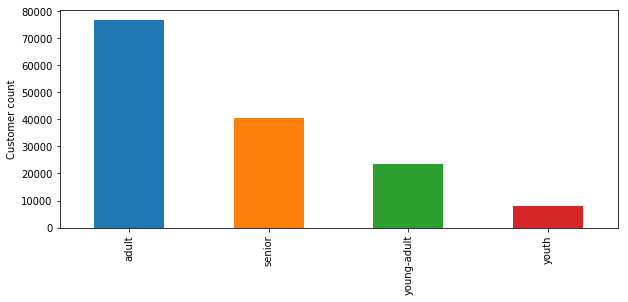

In [73]:
plt.figure(figsize=(10,4))
merged_dataset.age_group.value_counts().plot(kind='bar');
plt.ylabel('Customer count');
plt.show();

In [74]:
# Result: Most of the customers belong to adult age group ie., 40-65 years

In [75]:
# Analysis 2: What is the most popular offers across age groups

In [76]:
merged_dataset['offer_type'].value_counts()

bogo             63693
discount         62204
informational    22606
Name: offer_type, dtype: int64

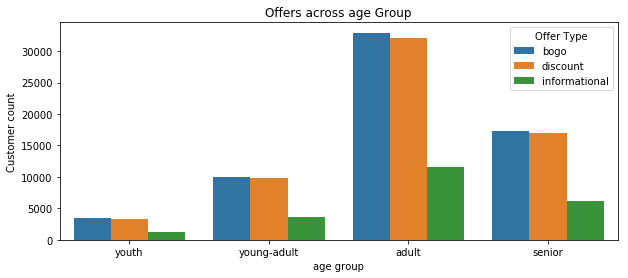

In [77]:
plt.figure(figsize=(10,4))
g = sns.countplot(x="age_group", hue="offer_type", data=merged_dataset)
plt.title('Offers across age Group')
plt.ylabel('Customer count')
plt.xlabel('age group')
plt.legend(title='Offer Type')
plt.show();

In [78]:
# Result:  Most Popular offer is bogo followed by discount across all age groups

In [79]:
# Analysis 3: What is the most popular offers across gender

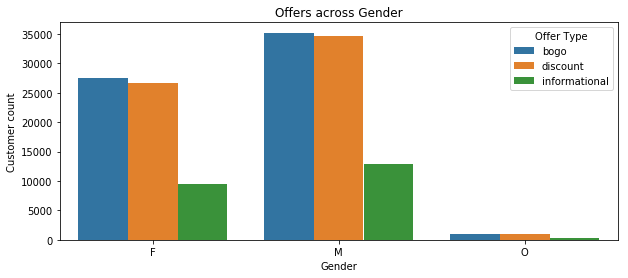

In [80]:
plt.figure(figsize=(10,4))
g = sns.countplot(x='gender', hue="offer_type", data=merged_dataset)
plt.title('Offers across Gender')
plt.ylabel('Customer count')
plt.xlabel('Gender')
plt.legend(title='Offer Type')
plt.show();

In [81]:
# Result: All genders seem to like bogo and discount offers and they have the same reaction toward informational offers

In [82]:
# Analysis 4: which gender is more favorable to promotions

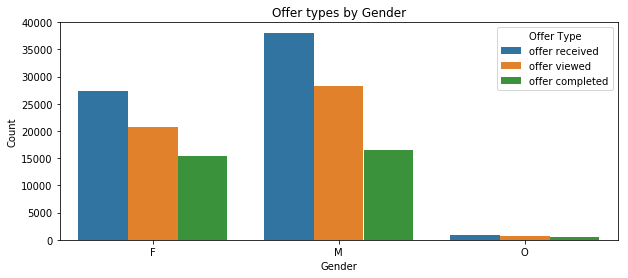

In [83]:
plt.figure(figsize=(10, 4))
g = sns.countplot(x='gender', hue="event", data=merged_dataset)
plt.title('Offer types by Gender')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.legend(title='Offer Type')
plt.show();

In [84]:
 female_gender_offer_viewed = merged_dataset[(merged_dataset['gender'] == 'F') & (merged_dataset['event'] == 'offer viewed')].count()['event']
 female_gender_offer_completed = merged_dataset[(merged_dataset['gender'] == 'F') & (merged_dataset['event'] == 'offer completed')].count()['event']
 female_gender_offer_acceptance= female_gender_offer_completed/female_gender_offer_viewed*100
 print(f'Female customers offer acceptance rate : {female_gender_offer_acceptance} %')

Female customers offer acceptance rate : 74.50214571580115 %


In [85]:
 male_gender_offer_viewed = merged_dataset[(merged_dataset['gender'] == 'M') & (merged_dataset['event'] == 'offer viewed')].count()['event']
 male_gender_offer_completed = merged_dataset[(merged_dataset['gender'] == 'M') & (merged_dataset['event'] == 'offer completed')].count()['event']
 male_gender_offer_acceptance= male_gender_offer_completed/male_gender_offer_viewed*100
 print(f'Male customers offer acceptance rate : {male_gender_offer_acceptance} %')

Male customers offer acceptance rate : 58.19849166165068 %


In [86]:
#Result:  we can see that Female customer offer acceptance rate (74%) is much higher than male customers (58%).
# we can infer that female customers respond favorbly to promotions

In [87]:
# Analysis 5: what is the dominant income range of the customers

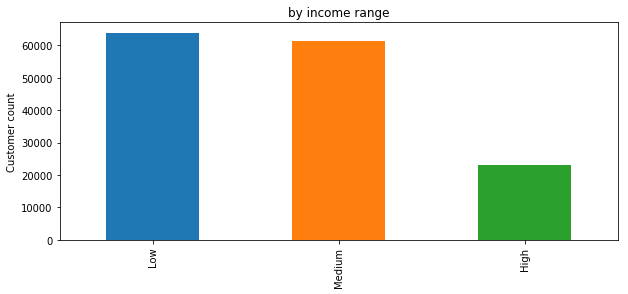

In [88]:
plt.figure(figsize=(10,4))
merged_dataset.income_range.value_counts().plot(kind='bar');
plt.title('by income range')
plt.ylabel('Customer count');
plt.show();

In [89]:
# Result: Highest number of customers fall into Low income range (30000 TO 60000) followed by Medium income range

In [90]:
# Analysis 6: Which offer type is completed more than other offer types?

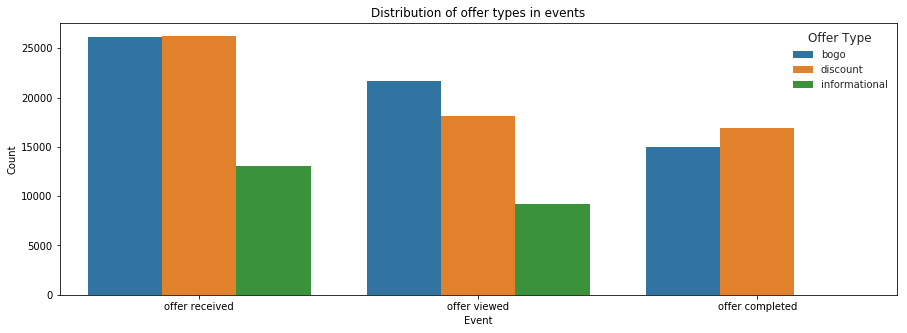

In [91]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "offer_type", data=merged_dataset[merged_dataset['gender'] != 'O'])
sns.set(style="darkgrid")
plt.title('Distribution of offer types in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type')
plt.show();

In [92]:
#Result: From the chart we can observe that discount offer is the most used offer by custumers

In [93]:
# Model build

In [94]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148503 entries, 0 to 167580
Data columns (total 22 columns):
event                      148503 non-null object
person                     148503 non-null object
time                       148503 non-null int64
calc_offer_id              148503 non-null object
amount                     148503 non-null int64
reward_x                   148503 non-null int64
gender                     148503 non-null object
customer_id                148503 non-null object
Membership_start_year      148503 non-null float64
income_range               148503 non-null category
age_group                  148503 non-null category
membership_tenure          148503 non-null float64
membership_tenure_group    148503 non-null object
difficulty                 148503 non-null int64
duration                   148503 non-null int64
offer_id                   148503 non-null object
offer_type                 148503 non-null object
reward_y                   148503 non-

In [95]:
merged_dataset.head()

,event,person,time,calc_offer_id,amount,reward_x,gender,customer_id,Membership_start_year,income_range,...,membership_tenure_group,difficulty,duration,offer_id,offer_type,reward_y,channel_email,channel_mobile,channel_social,channel_web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,F,78afa995795e4d85b5d9ceeca43f5fef,2017.0,High,...,1-3years,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0,M,e2127556f4f64592b11af22de27a7932,2018.0,Medium,...,<1year,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0,M,389bc3fa690240e798340f5a15918d5c,2018.0,Low,...,<1year,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,0,M,2eeac8d8feae4a8cad5a6af0499a211d,2017.0,Low,...,<1year,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,F,aa4862eba776480b8bb9c68455b8c2e1,2017.0,Low,...,<1year,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [96]:
#Converting variablesn into numericals for the model build
convert_age_group = merged_dataset['age_group'].astype('category').cat.categories.tolist()
new_age_group = {'age_group' : {k: v for k,v in zip(convert_age_group,list(range(1,len(convert_age_group)+1)))}}
merged_dataset.replace(new_age_group, inplace=True)

In [97]:
convert_event = merged_dataset['event'].astype('category').cat.categories.tolist()
new_event = {'event' : {k: v for k,v in zip(convert_event,list(range(1,len(convert_event)+1)))}}
merged_dataset.replace(new_event, inplace=True)

In [98]:
convert_income_range = merged_dataset['income_range'].astype('category').cat.categories.tolist()
new_income_range = {'income_range' : {k: v for k,v in zip(convert_income_range,list(range(1,len(convert_income_range)+1)))}}
merged_dataset.replace(new_income_range, inplace=True)

In [99]:
convert_offer_type = merged_dataset['offer_type'].astype('category').cat.categories.tolist()
new_offer_type = {'offer_type' : {k: v for k,v in zip(convert_offer_type,list(range(1,len(convert_offer_type)+1)))}}
merged_dataset.replace(new_offer_type, inplace=True)

In [100]:
convert_gender = merged_dataset['gender'].astype('category').cat.categories.tolist()
new_gender = {'gender' : {k: v for k,v in zip(convert_gender,list(range(1,len(convert_gender)+1)))}}
merged_dataset.replace(new_gender, inplace=True)

In [101]:
convert_offer_id = merged_dataset['offer_id'].astype('category').cat.categories.tolist()
new_offer_id = {'offer_id' : {k: v for k,v in zip(convert_offer_id,list(range(1,len(convert_offer_id)+1)))}}
merged_dataset.replace(new_offer_id, inplace=True)

In [102]:
# drop unneeded columns
merged_dataset = merged_dataset.drop(['Membership_start_year','membership_tenure_group'], axis=1)

In [103]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148503 entries, 0 to 167580
Data columns (total 20 columns):
event                148503 non-null int64
person               148503 non-null object
time                 148503 non-null int64
calc_offer_id        148503 non-null object
amount               148503 non-null int64
reward_x             148503 non-null int64
gender               148503 non-null int64
customer_id          148503 non-null object
income_range         148503 non-null int64
age_group            148503 non-null int64
membership_tenure    148503 non-null float64
difficulty           148503 non-null int64
duration             148503 non-null int64
offer_id             148503 non-null int64
offer_type           148503 non-null int64
reward_y             148503 non-null int64
channel_email        148503 non-null int64
channel_mobile       148503 non-null int64
channel_social       148503 non-null int64
channel_web          148503 non-null int64
dtypes: float64(1), int6

In [104]:
# Training and Testing 
# Splitting data into features and target labels
X = merged_dataset[['offer_id','time','amount','reward_x','difficulty','duration','offer_type','gender','age_group','income_range']]
Y = merged_dataset['event']
scaler = MinMaxScaler()
features = [ 'amount', 'reward_x', 'duration','time']
X_scaled = X.copy()
X_scaled[features] = scaler.fit_transform(X_scaled[features])
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [105]:
# Accuracy is the evaluation metric for this exercise
def model_score(model):
    pred = model.predict(X_test)
    errors = abs(pred - y_test)
    # Calculate mean absolute percentage error
    mean_APE = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mean_APE)
    return round(accuracy, 2)

In [106]:
# Decision Tree Classifier Model
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set: {round(dt.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {model_score(dt)}%')

Accuracy of Decision Tree classifier on training set: 92.7%.
Prediction Accuracy: 97.55%


In [107]:
# Random Forest Classifier Model
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)
print(f'Accuracy of RandomForest classifier on training set: {round(rf.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {model_score(rf)}%')

Accuracy of RandomForest classifier on training set: 92.7%.
Prediction Accuracy: 97.38%


In [108]:
# KNeighbors Classifier Model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(f'Accuracy of KNN classifier on training set: {round(knn.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {model_score(knn)}%')

Accuracy of KNN classifier on training set: 91.75%.
Prediction Accuracy: 96.93%


In [109]:
# storing the results into a table
models = [dt,rf,knn]
model_names = [type(n).__name__ for n in models]
training_accuracy = [x.score(X_train, y_train)*100 for x in models]
prediction_accuracy = [model_score(y) for y in models]
results = [training_accuracy, prediction_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Prediction Accuracy'])
# final result
results_df

,DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier
Training Accuracy,92.698672,92.698672,91.754132
Prediction Accuracy,97.550000,97.380000,96.930000


In [110]:
#from above we can see that Decisiontree and KNeighbors models have performed well. 
# Decisiontree has the best score on validation set data compared to other models based on prediction accuracy. Hence, We can use Decision tree to predict customer response for the offer

In [111]:
# Model Refinement
# Using Gridsearch to improve the model performance.
# To tune hyper-parameters to choose the best values for available dataset

In [120]:
# DecisionTreeClassifier hyper - parameters tuning
def dtree_grid_search(X,y,nfolds):
    #create grid dictionary of all values we want to test
    param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15),'splitter':['best', 'random'],
                  'min_samples_leaf':np.arange(1,10)}
    # decision tree model
    dtree_model=DecisionTreeClassifier()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

In [292]:
# list of best parameters to be tuned
dtree_grid_search(X_train, y_train,5)

{'criterion': 'gini',
 'max_depth': 12,
 'min_samples_leaf': 6,
 'splitter': 'best'}

In [121]:
# Tuned Decision Tree Classifier Model
dt1 = DecisionTreeClassifier(criterion='gini', max_depth=12, splitter='best', min_samples_leaf=6)
dt1.fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set: {round(dt1.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {model_score(dt1)}%')

Accuracy of Decision Tree classifier on training set: 92.68%.
Prediction Accuracy: 97.58%


In [ ]:
#There is a slight increase in the accuracy for Decision Tree Classifier Model. 
# use of tuned parameters criterion='gini', max_depth=12, splitter='best', min_samples_leaf=6 helped.

In [113]:
# RandomForestClassifier hyper - parameters tuning
def rf_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    param_grid = { 'n_estimators': [200, 500],'max_features': ['auto', 'sqrt', 'log2'],'max_depth' : [4,5,6,7,8],
                  'criterion' :['gini', 'entropy']}
    # rf classifier model
    rf_model=RandomForestClassifier()
    #use gridsearch to test all values
    rf_gscv = GridSearchCV(rf_model, param_grid, cv=nfolds)
    #fit model to data
    rf_gscv.fit(X, y)
    return rf_gscv.best_params_

In [114]:
# list of best parameters to be tuned
rf_grid_search(X_train, y_train,5)

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 500}

In [115]:
# Tuned Random Forest Classifier Model
rf1 = RandomForestClassifier(n_estimators = 500,criterion='gini',max_depth=8,max_features='log2' )
rf1.fit(X_train, y_train)
print(f'Accuracy of RandomForest classifier on training set: {round(rf1.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {model_score(rf1)}%')

Accuracy of RandomForest classifier on training set: 78.85%.
Prediction Accuracy: 92.95%


In [ ]:
# For initial random forst classification model, parameters used are n_estimators = 100, random_state = 42. prediction accuracy - 97.38%
# for tuned random forest classification model, parameters used are n_estimators = 500,criterion='gini',max_depth=8,max_features='log2' with prediction accuracy - 92.95%
#so initital paramters worked better for the accuracy.

In [116]:
# KNeighborsClassifier hyper - parameters tuning

def knn_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    param_grid = { 'n_neighbors': [3, 4, 5],'weights': ["uniform", "distance"],'leaf_size' :[15, 20]}
    # rf classifier model
    knn_model=KNeighborsClassifier()
    #use gridsearch to test all values
    knn_gscv = GridSearchCV(knn_model, param_grid, cv=nfolds)
    #fit model to data
    knn_gscv.fit(X, y)
    return knn_gscv.best_params_

In [117]:
# list of best parameters to be tuned
knn_grid_search(X_train, y_train,5)

{'leaf_size': 15, 'n_neighbors': 4, 'weights': 'distance'}

In [118]:
# Tuned KNeighbors Classifier Model
knn1 = KNeighborsClassifier(leaf_size=15,n_neighbors=4,weights='distance')
knn1.fit(X_train, y_train)
print(f'Accuracy of KNN classifier on training set: {round(knn1.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {model_score(knn1)}%')

Accuracy of KNN classifier on training set: 92.43%.
Prediction Accuracy: 97.33%


In [ ]:
# for initital KNeighborsClassifier model, prediction frequency is 96.93%
# for tuned KNeighborsClassifier model, with parameters leaf_size=15,n_neighbors=4,weights='distance', prediction accuracy increased to 97.33%

In [122]:
# storing the tuned results into a table
models = [dt1,rf1,knn1]
model_names = [type(n).__name__ for n in models]
training_accuracy = [x.score(X_train, y_train)*100 for x in models]
prediction_accuracy = [model_score(y) for y in models]
results = [training_accuracy, prediction_accuracy]
results_df1 = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Prediction Accuracy'])
# final result
results_df1

,DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier
Training Accuracy,92.681613,78.854701,92.433806
Prediction Accuracy,97.580000,92.950000,97.330000


In [124]:
# summarizing highest prediction accuracy with respect to models
models = [dt1,rf,knn1]
model_names = [type(n).__name__ for n in models]
training_accuracy = [x.score(X_train, y_train)*100 for x in models]
prediction_accuracy = [model_score(y) for y in models]
results = [training_accuracy, prediction_accuracy]
results_df2 = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Prediction Accuracy'])
# final result
results_df2

,DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier
Training Accuracy,92.681613,92.698672,92.433806
Prediction Accuracy,97.580000,97.380000,97.330000


In [ ]:
#From this final table, we can see that DecisionTreeClassifier performed better on Prediction accuracy. 
#Hence, We can use Decision tree to predict customer response for the offer

In [ ]:
# Import features derivation from the selected model
importance = dt1.feature_importances_

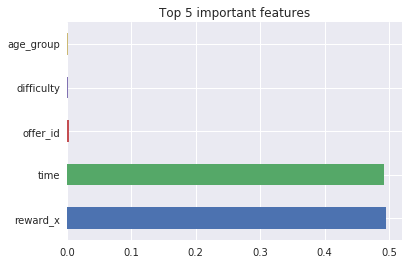

In [125]:
feat_importances = pd.Series(dt.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.title("Top 5 important features")
plt.show()

In [ ]:
# from the chart we can see that reward and time are the most important features for Decision Tree Classifier Model 

In [ ]:
# Model future improvements
# additional Model tuning,more feature engineering to identify features can be implemeted in future to improve the model 

In [921]:
# Conclusion (more detailed description provided on README.md file and medium blog)

#Project involved below steps.

#1. Data processing: a. analyzed the datasets
#                   b. cleaned the data
#                   c. preprocessed the data
#                   d. Merging the datasets 

#2. Data analaysis: performed data analysis on the data to answer the questions.
#                   Analysis 1: which age group customers mostly belong to
#                   Result: Most of the customers belong to adult age group ie., 40-65 years

#                   Analysis 2: What is the most popular offers across age groups
#                   Result:  Most Popular offer is bogo followed by discount across all age groups

#                   Analysis 3: What is the most popular offers across gender
#                   Result: All genders seem to like bogo and discount offers and they have the same reaction toward informational offers

#                   Analysis 4: which gender is more favorable to promotions
#                   Result:  we can see that Female customer offer acceptance rate (74%) is much higher than male customers (58%).
#                            we can infer that female customers respond favorbly to promotions

#                   Analysis 5: what is the dominant income range of the customers
#                   Result: Highest number of customers fall into Low income range (30000 TO 60000) followed by Medium income range

#                   Analysis 6: Which offer type is completed more than other offer types?
#                   Result: From the chart we can observe that discount offer is the most used offer by customers 
                    
                      
#3. Data modeling: a. Build model to predict customer response to offer
#                  b. used accuracy as evaluation metric to determine best model
#                  c. Decision Tree Classifier, Random Forest Classifier and KNeighbors Classifier models have been considered for this project.
#                  d. after initial scores,as part of model refinement, we employed GridSearch technique through which we can come to know the best parameters for a model.
#                  e. Decisiontree has the best prediction accuracy on validation set data compared to other models. Hence, We can use Decision tree to predict customer response for the offer. 
#                  f. Also, Reward and Time are the most important features for the model.
    
